# Homework 3

### Problem 1.1
Get the data and mask off nans that we'll care about in future

In [1]:
from astropy.io import fits
import numpy as np

file = fits.open('./data/allStarLite-dr17-synspec_rev1.fits')
data = file[1].data
#file[1].columns

feh_raw = data['FE_H']
alpham_raw = data['ALPHA_M']
dist_raw = data['GAIAEDR3_R_MED_GEO']

mask = np.logical_or(
            np.logical_or(np.isnan(feh_raw), np.isnan(alpham_raw)), 
            np.isnan(dist_raw))

feh = np.ma.masked_array(feh_raw, mask=mask)
alpham = np.ma.masked_array(alpham_raw, mask = mask)



### Problem 1.2

_Make a “Wallerstein–Tinsley Diagram”, versus
You’ll need to select only stars with finite and measurements (i.e. no NaN’s).
Probably best to create a 2-D histogram plot. Play with color scales or log-scaling the color
map to make the best-looking figure._

Below is the Wallsertein Tinsley Diagram showing the thin and thick disk separated by a drawn path. The thin disk has a lower fraction of alpha elements similar to what we discussed in class. Notably the thick disk structure seems to have 2 Additional maxima below the highest maxima around $[\alpha/H] = 0.3$. I wonder if these are separated out kinematically at all, or are the result of more than one prior merger.

The thin disk (low $\alpha$ maxima) has some significant banding in this view as well. Just so I have names for things: Below the line I see a bird, a branch, and an egg on the left hand side of the bird. I don't have a physical meaning to ascribe to these, but I need names so I can talk about them later.

Based on the analysis in Problem 2, I ended up coming back here and altering my line through this to a drawn border around the "bird" formation of the thin disk. I think this is giving me a greater ability to separate out halo stars in that later step and get a better estimate of scale height

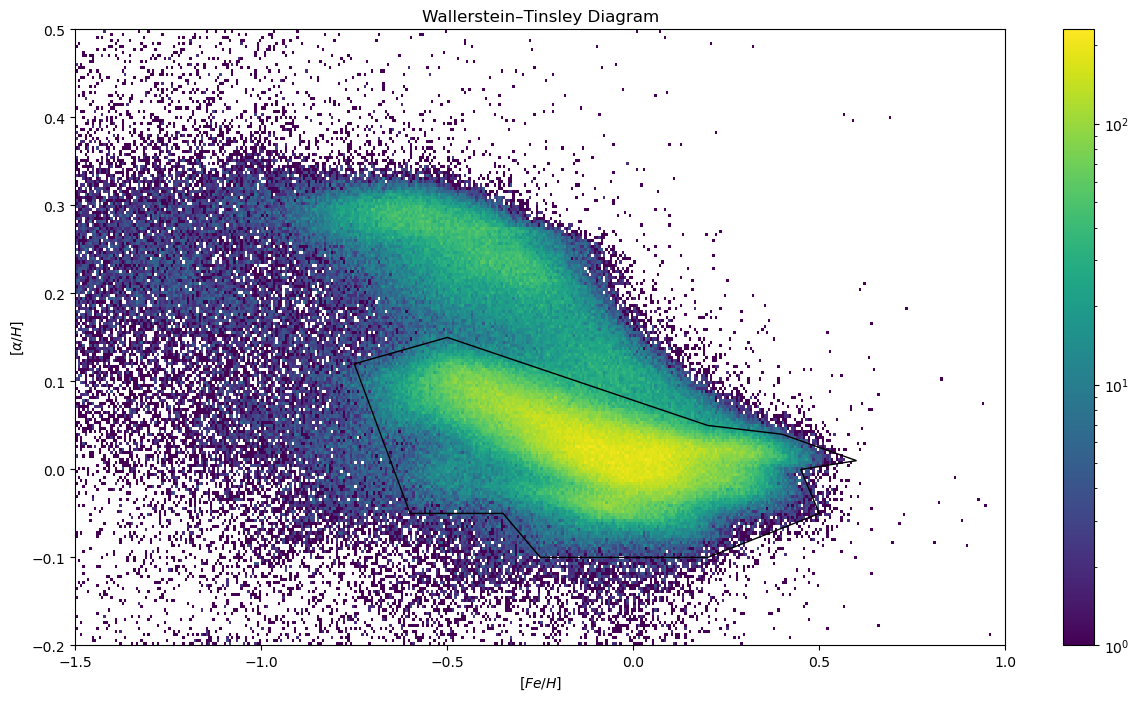

224.0

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.path import Path
import matplotlib.patches as patches


# A simple line
#thinDiskPath = Path([(-1.5, 0.26),(1.0, -0.02), (20.0,-100), (-20.0, -100), (-1.5, 0.25)], closed=True)

# Maybe a little better than a simple line
#thinDiskPath = Path([(-1.5, 0.0),(-0.5, 0.16),(1.0, 0), (20.0,-100), (-20.0, -100), (-1.5, 0.25)], closed=True)

# Something more drawn
thinDiskPath = Path([(-0.75, 0.12),(-0.5, 0.15),(0.2, 0.05),(0.4, 0.04), (0.6, 0.01),(0.45,0.0),(0.5, -0.05),(0.2,-0.1), (-0.25, -0.1), (-0.35,-0.05), (-0.6, -0.05),(0,0)], closed = True)
#thinDiskPath = Path([(-1.5, 0.24), (1.0, -0.04), (20.0,-100), (-20.0, -100), (-1.5, 0.25)], closed=True)

thickDiskMask = np.logical_or(mask, thinDiskPath.contains_points(np.column_stack((feh_raw,alpham_raw))))
thinDiskMask = np.logical_or(mask, np.logical_not(thickDiskMask))


feh = np.ma.masked_array(feh_raw, mask=mask)
alpham = np.ma.masked_array(alpham_raw, mask = mask)

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
plt.title("Wallerstein–Tinsley Diagram")
plt.xlabel("$[Fe/H]$")
plt.ylabel("$[\\alpha/H]$")

h, _, _, _= plt.hist2d(feh.compressed(), alpham.compressed(), bins=(400,200), range=((-1.5, 1),(-0.2, 0.5)), norm=colors.LogNorm(1,230))
plt.colorbar()

ax.add_patch(patches.PathPatch(thinDiskPath, fill=False))

plt.show()
np.max(h)




### Problem 1.3

Looking at the below two Wallerstein-Tinsley diagrams for Dwarf and Giant stars, the thin and thick disk are quite visible in the giant stars, but the thick disk is much less visible in the Dwarf stars

There's also this interesting break-up of the sub-structure of the thin disk between giants and dwarfs. Dwarf stars have the lower body and branch of the bird, and Giants have the upper body and the egg.
<Which galactic disks can you see for each of these two stellar populations?>

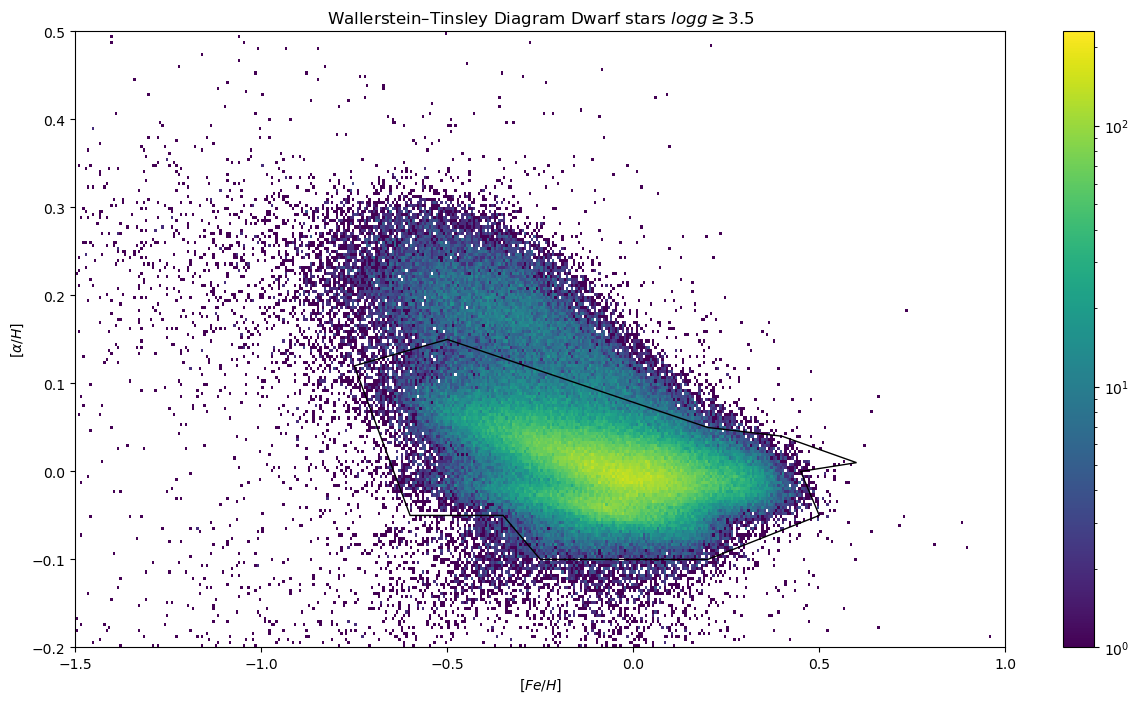

156.0

In [3]:
dwarf_mask = np.logical_or(mask, np.less(data['LOGG'], 3.5))

feh_dwarf = np.ma.masked_array(feh_raw, mask=dwarf_mask)
alpham_dwarf = np.ma.masked_array(alpham_raw, mask = dwarf_mask)

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
plt.title("Wallerstein–Tinsley Diagram Dwarf stars $log g \geq 3.5$")
plt.xlabel("$[Fe/H]$")
plt.ylabel("$[\\alpha/H]$")

h, _, _, _= plt.hist2d(feh_dwarf.compressed(), alpham_dwarf.compressed(), bins=(400,200), range=((-1.5, 1),(-0.2, 0.5)), norm=colors.LogNorm(1,230))
plt.colorbar()

ax.add_patch(patches.PathPatch(thinDiskPath, fill=False))

plt.show()
np.max(h)

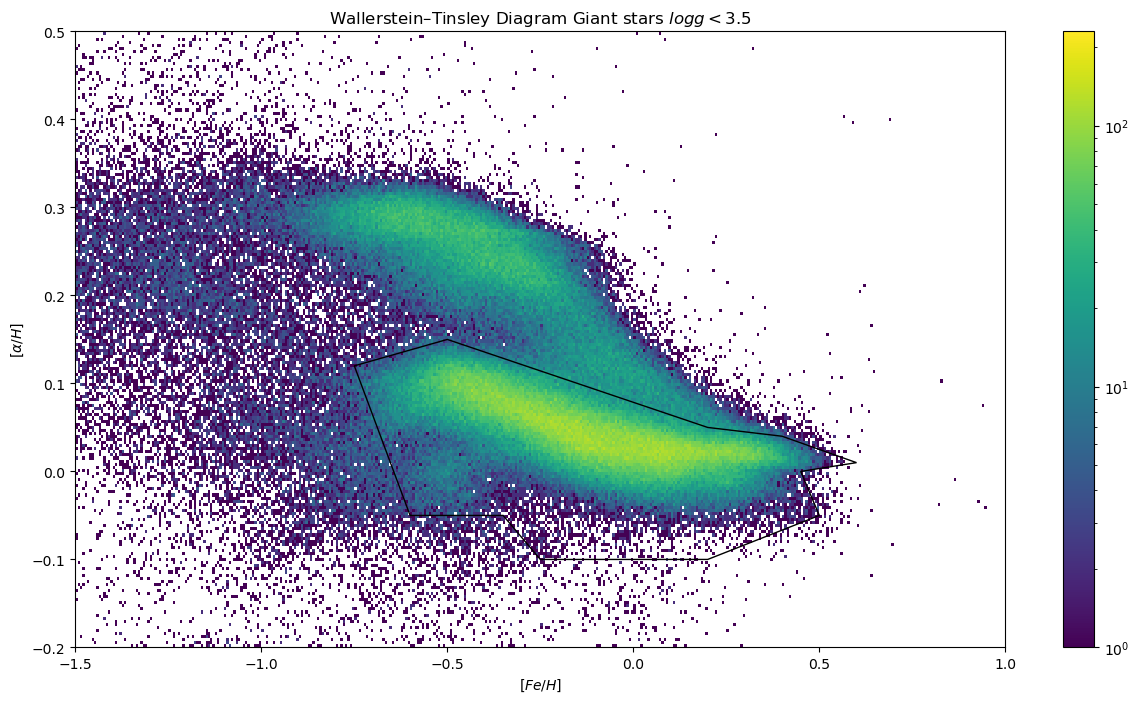

134.0

In [4]:
giant_mask = np.logical_or(mask, np.greater_equal(data['LOGG'], 3.5))

feh_giant = np.ma.masked_array(feh_raw, mask=giant_mask)
alpham_giant = np.ma.masked_array(alpham_raw, mask = giant_mask)


fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
plt.title("Wallerstein–Tinsley Diagram Giant stars $log g < 3.5$")
plt.xlabel("$[Fe/H]$")
plt.ylabel("$[\\alpha/H]$")

h, _, _, _= plt.hist2d(feh_giant.compressed(), alpham_giant.compressed(), bins=(400,200), range=((-1.5, 1),(-0.2, 0.5)), norm=colors.LogNorm(1,230))
plt.colorbar()

ax.add_patch(patches.PathPatch(thinDiskPath, fill=False))

plt.show()
np.max(h)

### Problem 2.1
The Histograms below plot fraction of the sample per bin for Thin/Thick disk identified by abundance, as well as giants and dwarfs identified by $log(g)$.  The Giants trace the thick disk better, while the dwarfs trace the thin disk better. There is a dip in the center of the dwarf histogram and a spike in the center of the Giants histogram. I think this is due to dwarfs at z near to zero being hard to see, and giants being easier to see because there's more dust and other stars right in the center of the thin disk.

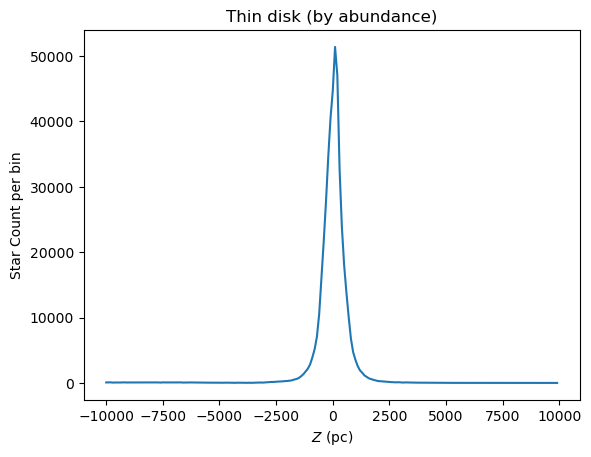

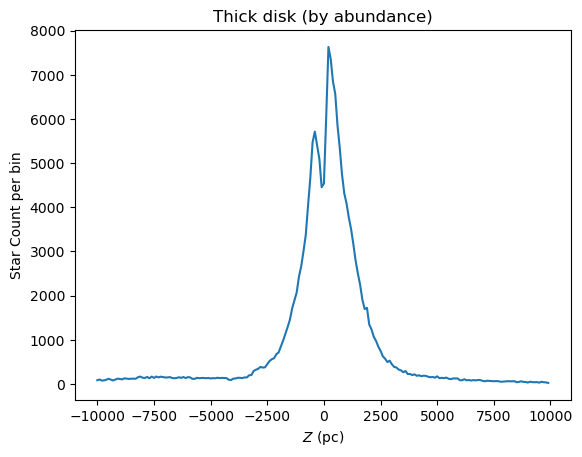

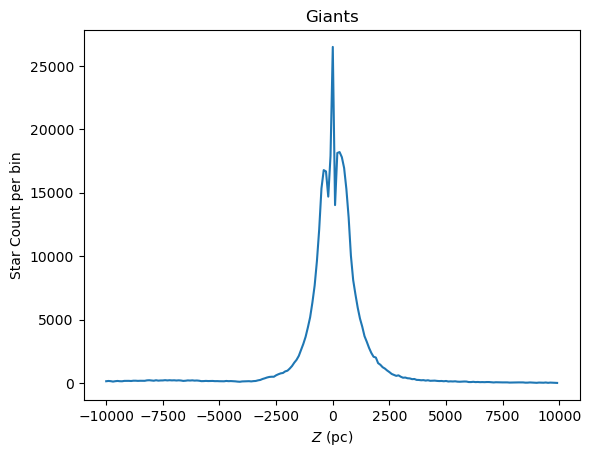

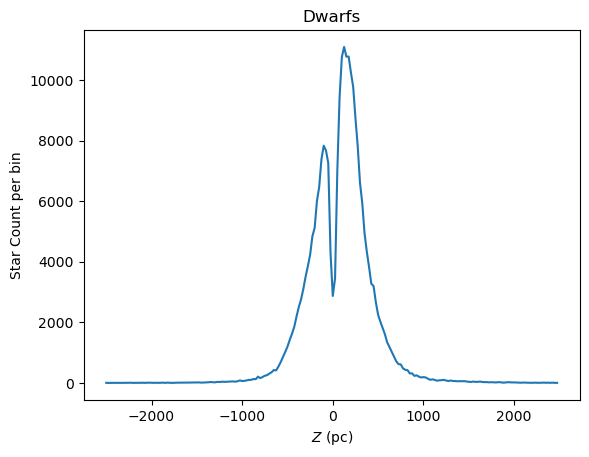

In [5]:
import astropy.coordinates as coords
import astropy.units as u
from astropy.modeling import models, fitting

sky_coords = coords.SkyCoord(ra = data['RA'] * u.deg, dec = data['DEC'] * u.deg, distance = data['GAIAEDR3_R_MED_GEO']*u.pc)
xyz_coords = sky_coords.transform_to(coords.Galactocentric)


def plot_zdist(xyz_coords, plotmask, range = (-10000,10000)):
    masked_z_coords = np.ma.masked_array(xyz_coords.z.value, plotmask)
    hist, bins =np.histogram(masked_z_coords.compressed(), bins = 200, range = range)
    plt.plot(bins[:-1], hist)
    plt.xlabel("$Z$ (pc)")
    plt.ylabel("Star Count per bin")
    plt.show()


plt.title("Thin disk (by abundance)")
plot_zdist(xyz_coords, plotmask=thinDiskMask)

plt.title("Thick disk (by abundance)")
plot_zdist(xyz_coords, plotmask=thickDiskMask)

plt.title("Giants")
plot_zdist(xyz_coords, plotmask=giant_mask)

plt.title("Dwarfs")
plot_zdist(xyz_coords, plotmask=dwarf_mask, range=(-2500,2500))



Also, noting that the thick disk goes out to $Z=\pm 1700 pc$, we can plot a 2d histogram of Z vs $log(g)$. The dwarfs on the right of the histogram have a smaller feature size, where the Giants seem to spread out and dominate the size range of the thick disk. Note that the central features of a spike in the giants at Z=0 and a underabundance of the dwarfs are visible on the plot as horizontal features.

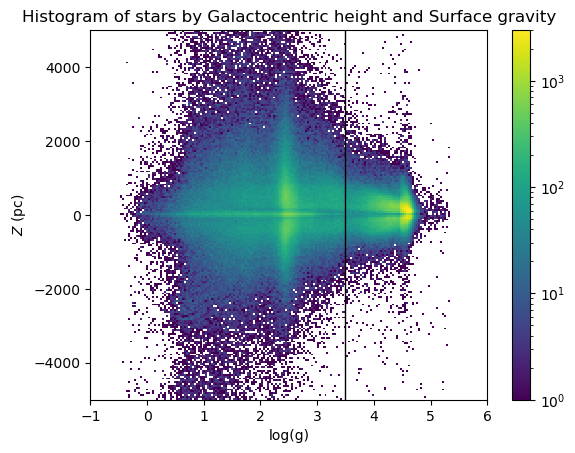

3427.0

In [6]:
plotmask = mask

# ra = np.ma.masked_array(data['RA'], mask = plotmask)
# dec = np.ma.masked_array(data['DEC'], mask = plotmask)
# distance = np.ma.masked_array(data['GAIAEDR3_R_MED_GEO'], mask = plotmask)
logg = np.ma.masked_array(data['LOGG'], mask = plotmask)


# sky_coords = coords.SkyCoord(ra = ra.compressed() * u.deg, dec = dec.compressed() * u.deg, distance=distance.compressed() * u.pc)
# xyz_coords = sky_coords.transform_to(coords.Galactocentric)

masked_z_coords = np.ma.masked_array(xyz_coords.z.value, mask=plotmask)

fig, ax = plt.subplots()
h, _ , _ , _ = plt.hist2d(logg.compressed(), masked_z_coords.compressed(), bins = (200,200), range = ((-1,6),(-5000, 5000)), norm=colors.LogNorm(1,3000))

ax.add_patch(patches.PathPatch(Path([(3.5, -5000), (3.5, 5000)]), fill=False))

plt.title("Histogram of stars by Galactocentric height and Surface gravity")
plt.xlabel("log(g)")
plt.ylabel("$Z$ (pc)")

plt.colorbar()
plt.show()
h.max()

#xyz_thick = np.ma.masked_array(xyz_coords, mask=np.logical_or(mask, thickDiskMask))
#xyz_thin = np.ma.masked_array(xyz_coords, mask=np.logical_or(mask, thinDiskMask))


### Scale Height
In order to come up with a scale height, I'm fitting two gaussians, one for the disk and one for the halo to the log density of stars. Because we're working in log space the fit is extremely sensitive to the tails of the distribution, much more than the peak and peak shape (which is great, because all the peaks have weird defects!)

When I had a simple line cut for the thin/thick disk in chemical space, these were very messy, and the halo stars were dominating the tails of my thin disk. This caused me to return to my thin disk cut and do a more drawn border. I'm still catching halo stars, but the scale height of the thin disk is now resolvable as 692 pc, which is not great, but also not nearly as bad as it was before. The thick disk I get a scale height of 1700 pc.

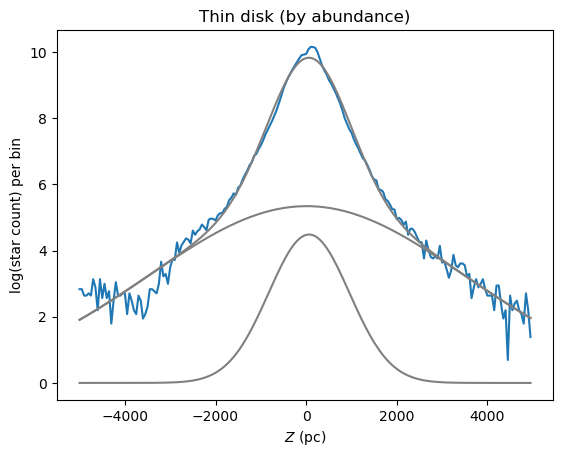

Disk Fit Avg: 63.79004130741668 Stdev: 891.3396838671296
Halo Fit Avg: 10.718316033385987 Stdev: 3490.848658457947


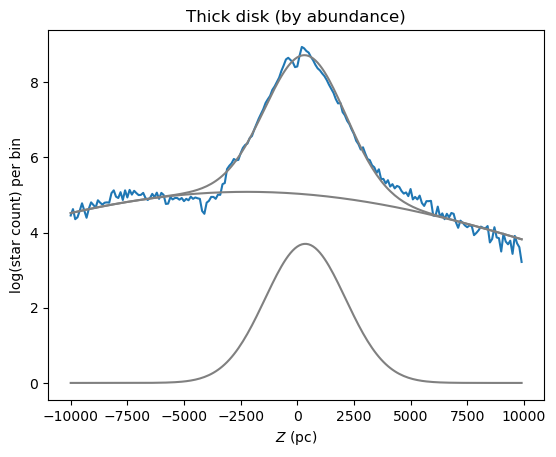

Disk Fit Avg: 354.8324017874921 Stdev: 1773.3048739581186
Halo Fit Avg: -2216.3409884616835 Stdev: 16039.630464022004


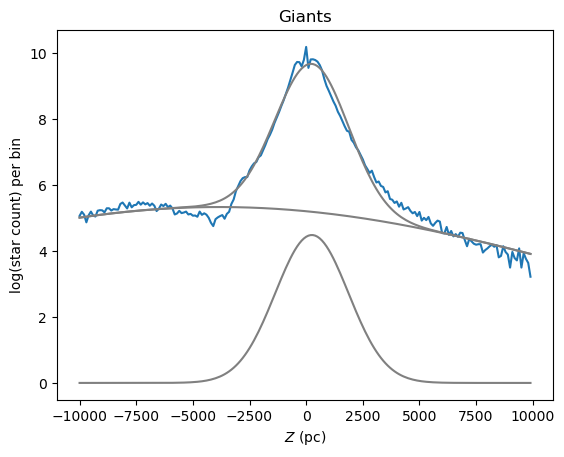

Disk Fit Avg: 251.5398246119842 Stdev: 1617.283293073234
Halo Fit Avg: -3840.175097064367 Stdev: 17452.61523620232


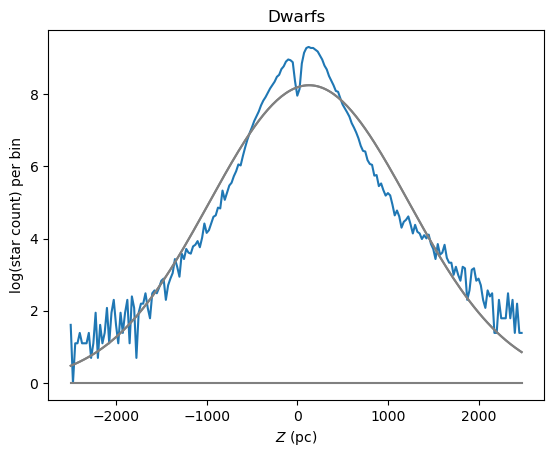

Disk Fit Avg: 130.20492919271055 Stdev: 1101.0553310717064
Halo Fit Avg: 3535.0289288693984 Stdev: 1.1754943508222875e-38


In [7]:
def plot_zdist_log(xyz_coords, plotmask, range = (-10000,10000)):
    masked_z_coords = np.ma.masked_array(xyz_coords.z.value, plotmask)
    hist, bins =np.histogram(masked_z_coords.compressed(), bins = 200, range = range)

    fit = fitting.LevMarLSQFitter()
    halo = models.Gaussian1D(4, 0, 10000)
    disk = models.Gaussian1D(10, 0, 1000)

    model = halo + disk

    fitted_gaussian = fit(model, bins[:-1], np.log(hist), maxiter=1000)

    plt.plot(bins[:-1], np.log(hist))
    plt.plot(bins[:-1], fitted_gaussian(bins[:-1]), color="grey")
    plt.plot(bins[:-1], fitted_gaussian[0](bins[:-1]), color="grey")
    plt.plot(bins[:-1], fitted_gaussian[1](bins[:-1]), color="grey")
    plt.xlabel("$Z$ (pc)")
    plt.ylabel("log(star count) per bin")
    plt.show()
    print(f"Disk Fit Avg: {fitted_gaussian[1].parameters[1]} Stdev: {fitted_gaussian[1].parameters[2]}")
    print(f"Halo Fit Avg: {fitted_gaussian[0].parameters[1]} Stdev: {fitted_gaussian[0].parameters[2]}")

plt.title("Thin disk (by abundance)")
plot_zdist_log(xyz_coords, plotmask=thinDiskMask, range=(-5000,5000))

plt.title("Thick disk (by abundance)")
plot_zdist_log(xyz_coords, plotmask=thickDiskMask)

plt.title("Giants")
plot_zdist_log(xyz_coords, plotmask=giant_mask)

plt.title("Dwarfs")
plot_zdist_log(xyz_coords, plotmask=dwarf_mask, range=(-2500,2500))


## Problem 2.2
Plot the mean metallicity $[Fe/H]$ of stars in the (R, Z) plane

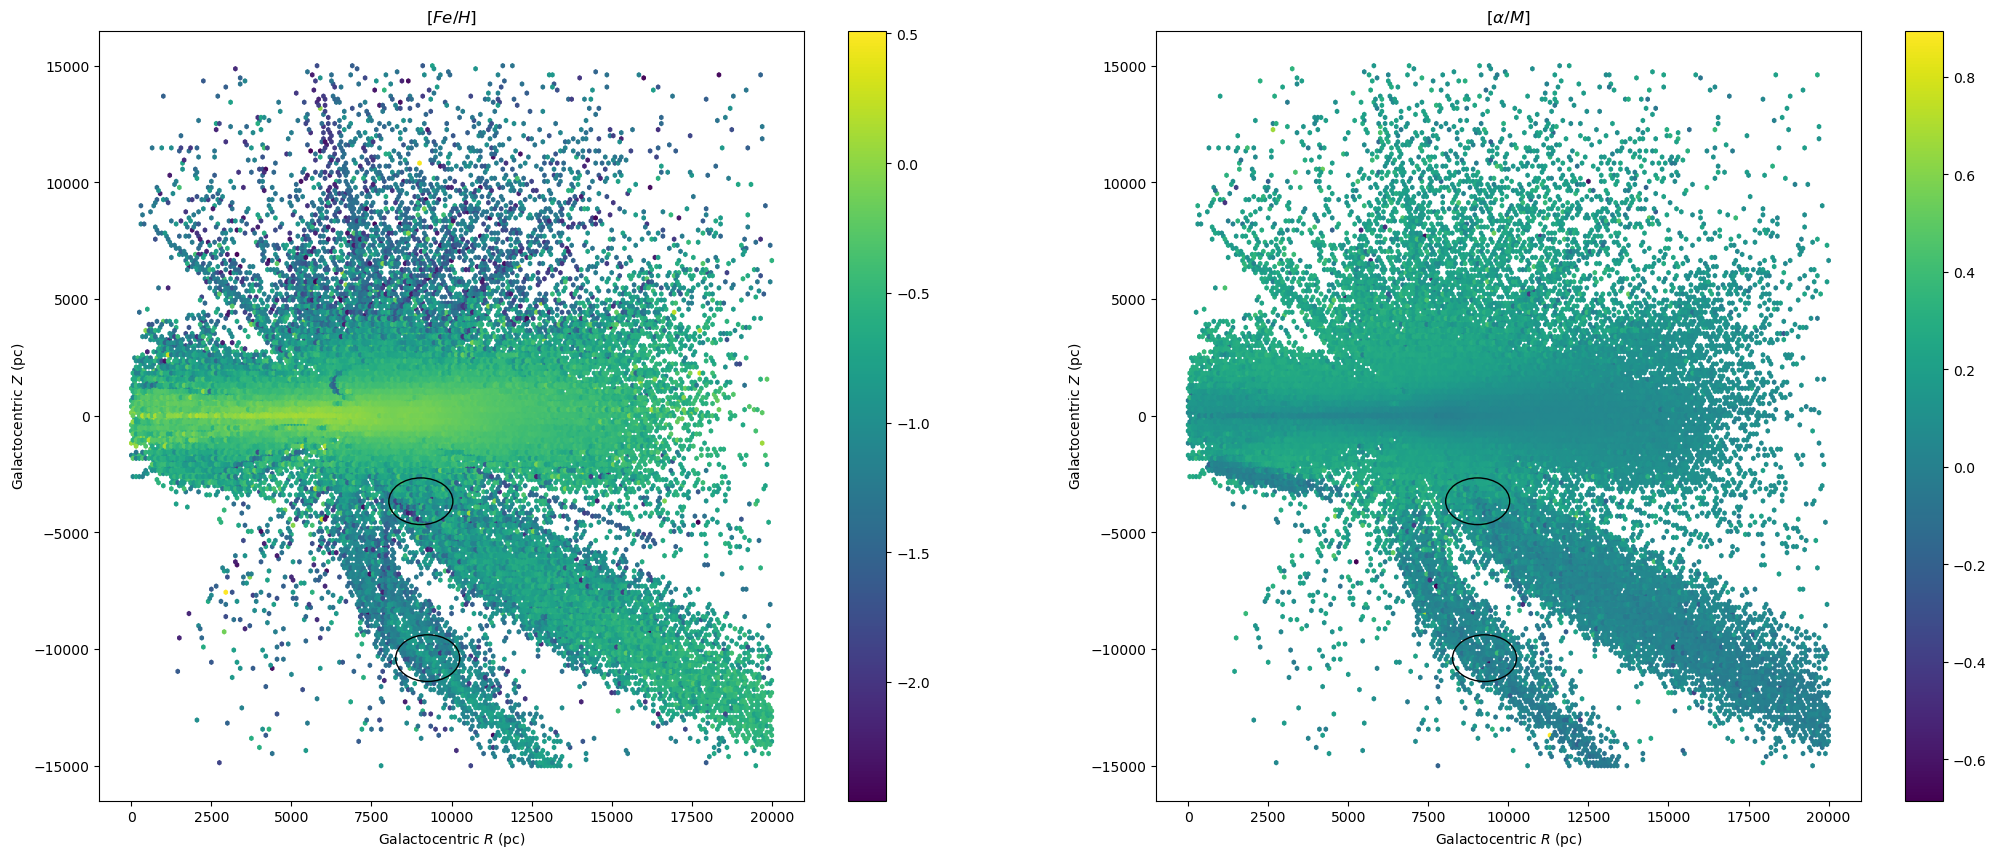

In [8]:
r_coords = np.sqrt(xyz_coords.x.value**2 + xyz_coords.y.value**2)

def plot_metalicity(data, xyz_coords, r_coords, plotmask, ax = None):
    masked_z_coords = np.ma.masked_array(xyz_coords.z.value, mask=plotmask)
    masked_r_coords = np.ma.masked_array(r_coords, mask=plotmask)
    masked_data = np.ma.masked_array(data, mask=plotmask)

    if ax != None:
        ax.set_xlabel("Galactocentric $R$ (pc)")
        ax.set_ylabel("Galactocentric $Z$ (pc)")

        im = ax.hexbin(masked_r_coords.compressed(), masked_z_coords.compressed(), gridsize = 200, C = masked_data.compressed(), reduce_C_function=np.mean, extent=(0,20000,-15000, 15000))
        plt.colorbar(im)
    

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

fig.set_size_inches(25, 10)

ax1.set_title("$[Fe/H]$")
plot_metalicity(feh_raw, xyz_coords, r_coords, plotmask=mask, ax=ax1)

ax2.set_title("$[\\alpha/M]$")
plot_metalicity(alpham_raw, xyz_coords, r_coords, plotmask=mask, ax=ax2)

lmc = coords.SkyCoord(80.8928247423*u.deg, -69.7560497231*u.deg, 	6785 *u.pc).transform_to(coords.Galactocentric)
lmc_r = np.sqrt(lmc.x**2 + lmc.y**2)
ax1.add_patch(plt.Circle((lmc_r.value, lmc.z.value), 1000, color='black', fill=False))
ax2.add_patch(plt.Circle((lmc_r.value, lmc.z.value), 1000, color='black', fill=False))

smc = coords.SkyCoord(13.1579469482*u.deg,  -72.8003552225*u.deg, 	14877 *u.pc).transform_to(coords.Galactocentric)
smc_r = np.sqrt(smc.x**2 + smc.y**2)
ax1.add_patch(plt.Circle((smc_r.value, smc.z.value), 1000, color='black', fill=False))
ax2.add_patch(plt.Circle((smc_r.value, smc.z.value), 1000, color='black', fill=False))

# sagdec = coords.SkyCoord(coords.Angle("18h 55m"),  coords.Angle("-30d29m"), (78000*u.lyr).to(u.pc)).transform_to(coords.Galactocentric)
# sagdec_r = np.sqrt(sagdec.x**2 + sagdec.y**2)
# ax1.add_patch(plt.Circle((sagdec_r.value, sagdec.z.value), 1000, color='black', fill=False))

# canis = coords.SkyCoord(108.1515022822*u.deg, -27.6669741798*u.deg, 7665 *u.pc).transform_to(coords.Galactocentric)
# print(canis)
# canis_r = np.sqrt(canis.x**2 + canis.y**2)
# ax1.add_patch(plt.Circle((canis_r.value, canis.z.value), 1000, color='black', fill=False))



First off, its very clear that the thin disk, thick disk, and halo have distinct populations of stars. From $[Fe/H]$ I can see that the halo stars are the oldest, and the newest star formation occurs in the thin disk. I'm also seeing that the thin disk has the lowest alpha abundance, but this changes as we go in toward the core, and also as we go out to the halo.

I've circled the SMC and LMC on the $[\alpha/FE]$ plot, and we can see from their lower alpha abundance than the milky way halo stars, that they formed in an environment where there was less supernova activity. Presumably the early SMC/LMC was less violent in the past than the milky way was. We can tell by looking at the $[Fe/H]$ plot that the SMC and LMC are primarily older stars in comparison to star forming regions in the milky way that are more metal-rich, like the thin disk.

I think I'm seeing tidal streams as long thin dark regions of the Fe/H plot. I'm seeing older metal poor stars that appear to be in the halo. Some of these streams, especially the ones on the bottom of the plot are slightly lower in alpha elements than the MWY, indicating that they may be the result of a prior merger. 

Several of the upper streams I think are simply good windows into the halo stars, so we get many detections. I'm midly suspicious of any feature that points toward earth at (8000,0), as being potentially part created by some sort of measurement error.

There is a smudge of high alpha and high metallicity near the galactic center I thought perhaps this was another galaxy, but it doesn't match the known locations of nearby dwarf galaxies. Perhaps this is the result of some supernova or AGN activity near the galactic core in the past.

## Problem 3

423.0


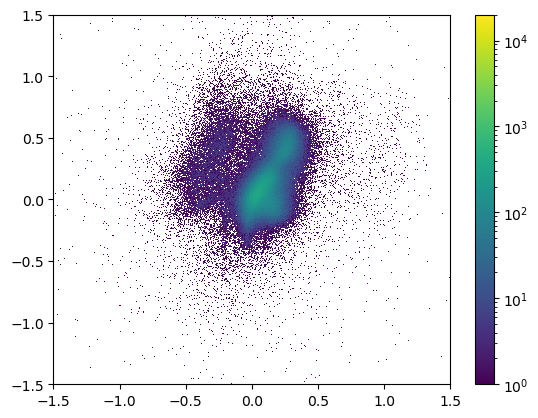

In [9]:
mgfe_raw = data['MG_FE']
mnfe_raw = data['MN_FE']
alfe_raw = data['AL_FE']

mask_chem = np.logical_or(np.logical_or(mask, np.isnan(mgfe_raw)), np.logical_or(np.isnan(mnfe_raw), np.isnan(alfe_raw)))

mgfe = np.ma.masked_array(mgfe_raw, mask=mask_chem)
mnfe = np.ma.masked_array(mnfe_raw, mask=mask_chem)
alfe = np.ma.masked_array(alfe_raw, mask=mask_chem)

mgmn = mgfe.compressed() - mnfe.compressed()

fig,ax = plt.subplots(nrows=1, ncols=1)
h, _, _, im = ax.hist2d(alfe.compressed(), mgmn, bins=(500,500), range=((-1.5,1.5), (-1.5, 1.5)), norm=colors.LogNorm(1,20000))

plt.colorbar(im)

print(np.max(h))




In [19]:
pmra_raw = data['GAIAEDR3_PMRA']
pmdec_raw = data['GAIAEDR3_PMDEC']
rvel_raw = data['GAIAEDR3_DR2_RADIAL_VELOCITY']

mask_dyn = np.logical_or(
            np.logical_or(mask, np.isnan(rvel_raw)), 
            np.logical_or(np.isnan(pmdec_raw), np.isnan(pmra_raw)))

pmra = np.ma.masked_array(pmra_raw, mask=mask_dyn)
pmdec = np.ma.masked_array(pmdec_raw, mask=mask_dyn)
rvel = np.ma.masked_array(rvel_raw, mask=mask_dyn)

print(rvel.count())

sky_coords_vel = coords.SkyCoord(ra = data['RA'] * u.deg, 
                                 dec = data['DEC'] * u.deg, 
                                 distance = data['GAIAEDR3_R_MED_GEO']*u.pc, 
                                 pm_ra_cosdec = pmra*u.mas/u.yr, 
                                 pm_dec = pmdec*u.mas/u.yr, 
                                 radial_velocity=rvel * u.km/u.s)
xyz_coords_vel = sky_coords_vel.transform_to(coords.Galactocentric)


294929


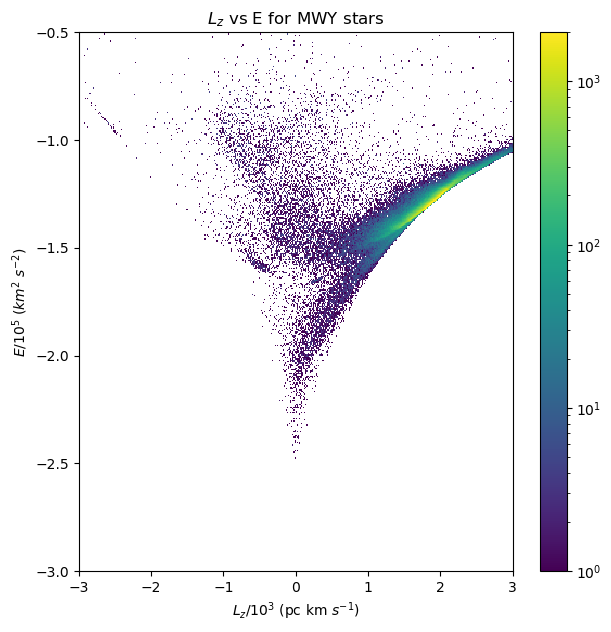

3020.0

In [21]:
import gala.potential as gp


L_vec = np.cross(np.column_stack((xyz_coords_vel.x, xyz_coords_vel.y, xyz_coords_vel.z)), np.column_stack((xyz_coords_vel.v_x, xyz_coords_vel.v_y, xyz_coords_vel.v_z)))
L_z = - L_vec[:,2].to(u.kpc*u.km/u.s)
#print("L_vec")
#print(L_vec[:20])
#print(L_vec[:20,2])
#L_mag = np.linalg.norm(L_vec, axis=1)
#print("L")
#print(L_mag[:20])

E_kinetic = (xyz_coords_vel.v_x**2 + xyz_coords_vel.v_y**2 + xyz_coords_vel.v_z**2)/2
#print(E_kinetic[:10])
E_potential = gp.MilkyWayPotential().energy([xyz_coords.x.value, xyz_coords.y.value, xyz_coords.z.value]*u.pc).to(u.km**2/u.s**2)
#print(E_potential[:10])
#print(len(E_potential))
#print(len(E_kinetic))
E_total = E_kinetic + E_potential

fig, ax = plt.subplots()
fig.set_size_inches(7,7)
ax.set_title("$L_z$ vs E for MWY stars")
ax.set_xlabel("$L_z/10^3$ (pc km $s^{-1}$)")
ax.set_ylabel("$E/10^5$ ($km^2$ $s^{-2}$)")
h,_,_,im =plt.hist2d(L_z.value/10**3, E_total.value/10**5, bins=(400,400), range=((-3,3),(-3, -0.5)),  norm=colors.LogNorm(1,2000))
plt.colorbar()
plt.show()
np.max(h)
